In [2]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import DBSCAN
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

In [3]:
data = pd.read_csv('./File/PointCloud_2023_02_21_14_59.csv')

In [4]:
data['Time'][0]

145948441895.0

In [94]:
145948441895
145948441895
145948448875
60000000000    

60000000000

In [95]:
print(145948448875 - 145948441895)

6980


In [5]:
data

,Frame,X,Y,Z,Doppler,SNR,Time
0,1.0,-2.658551,2.741712,0.538183,0.2618,1.240000,1.459484e+11
1,1.0,-2.663078,2.746380,0.855460,0.2618,1.120000,1.459484e+11
2,1.0,5.692171,2.897134,1.563014,0.0000,13.120000,1.459484e+11
3,1.0,3.340676,1.575976,-0.520531,0.0000,62.999999,1.459484e+11
4,1.0,3.743520,1.905333,-0.549163,0.0000,21.240000,1.459484e+11
...,...,...,...,...,...,...,...
281173,1726.0,-1.849286,1.869360,-0.370557,0.0000,224.519995,1.501119e+11
281174,1726.0,-2.048629,2.029860,-0.377041,0.0000,17.640000,1.501119e+11
281175,1726.0,-1.857516,2.034319,0.388209,0.0000,10.640000,1.501119e+11
281176,1726.0,-2.040343,1.652636,-0.396833,0.0000,255.519994,1.501119e+11


In [6]:
data['Frame'] = data['Frame'].astype(int)
data['X'] = data['X'].astype(np.float64)
data['Y'] = data['Y'].astype(np.float64)
data['Z'] = data['Z'].astype(np.float64)
data['Doppler'] = data['Doppler'].astype(np.float64)
data['SNR'] = data['SNR'].astype(np.float64)
data['Time'] = data['Time'].astype(np.float64)

In [7]:
data.describe()

,Frame,X,Y,Z,Doppler,SNR,Time
count,281178.000000,281178.000000,281178.000000,281178.000000,281178.000000,281178.000000,2.811780e+05
mean,798.288465,0.503385,2.621870,0.136869,-0.000827,68.708363,1.492856e+11
std,489.881592,1.737758,2.010729,0.657455,0.300180,157.322902,1.584027e+09
min,1.000000,-6.487724,0.000000,-4.168079,-8.249080,0.000000,1.459484e+11
25%,379.000000,-0.337986,0.984219,-0.352999,0.000000,8.520000,1.500044e+11
50%,696.000000,0.000000,2.441941,0.000000,0.000000,17.760000,1.500202e+11
75%,1224.000000,0.975342,4.097932,0.370557,0.000000,63.359999,1.500466e+11
max,1726.000000,6.540347,12.736001,2.733035,8.380120,2619.119941,1.501119e+11


# Functions

In [8]:
def Normalize(x, x_min, x_max):
    return (x-x_min)/(x_max-x_min)

In [9]:
# Normalize a list of intensity to [0,1] as weights
from sklearn.preprocessing import MinMaxScaler
def Weight(datalist):
    return MinMaxScaler().fit_transform(np.asarray(datalist).reshape(-1,1)).reshape(1,-1)[0]

In [10]:
# Reshape numpy arrays
def HorToVer(array):
    return array.reshape(-1,1)
def VerToHor(array):
    return array.reshape(1,-1)

In [11]:
# Angle between two vectors (0-1, 0=vertical, 1=parallel direction (same or opposite))
def VectorAngle(vec1, vec2):
    return np.abs(np.dot(vec1, vec2))/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [12]:
# Transform between cartesian and spherical coodinates
# theta: 0~2 pi, phi: 0~pi

def CarToSph(x, y, z):
    R = np.sqrt(x**2+y**2+z**2)
    theta = np.arctan2(y, x)
    if theta < 0:
        theta += 2*np.pi
    phi = np.arctan2(np.sqrt(x**2+y**2), z)
    return R, theta, phi

def SphToCar(R, theta, phi):
    x = R * np.cos(theta) * np.sin(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(phi)
    return x, y, z

In [13]:
def GetColors(label_list):
    color_list = ['r', 'b', 'g','c',  'm', 'darkorange', 'deepskyblue', 'blueviolet', 'orangered', 'crimson', 'k','lightblue','navy','purple','chocolate','darkblue','lime','pink','violet']
    return list(map(lambda x: color_list[x], label_list))

# plot data points

In [14]:
def PlotData(ax, datalist, **kwargs):
    datalist = datalist.reset_index()

    if 'color' not in kwargs.keys():
        kwargs['color'] = ['k']*len(datalist)
    elif len(kwargs['color']) != len(datalist):
        kwargs['color'] = list(kwargs['color'])*len(datalist)

    for i in range(len(datalist)):
        ax.scatter(datalist.X[i], datalist.Y[i], datalist.Z[i], color = kwargs['color'][i], marker = '.')
    print("==============================Print Point Clouds==============================")

In [15]:
# Plot settings
def PlotSetting(ax):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# DBSCAN clustering

In [16]:
WINDOW = 5

# Define global variables (dbscan)
DBSCAN_EPS = 0.1
DBSCAN_SAMPLES = 10

In [17]:
def ModelCluster(datalist, model, sample_weight=True, show_plot=True, return_cluster=False):
    if sample_weight:
        sample_weight = Weight(datalist)
    else:
        sample_weight = None
    clustering = model.fit(np.asarray(datalist.iloc[:,1:4]), sample_weight = sample_weight)
    
    if show_plot:
        fig = plt.figure()
        ax = fig.add_subplot(projection = '3d')
        PlotSetting(ax)
        
        PlotData(ax, datalist, color = GetColors(clustering.labels_))
        
        plt.show()
    
    if return_cluster:
        return clustering

Frame : 126
==============================Print Point Clouds==============================


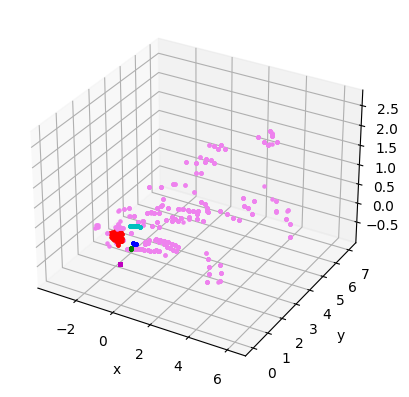

Frame : 127
==============================Print Point Clouds==============================


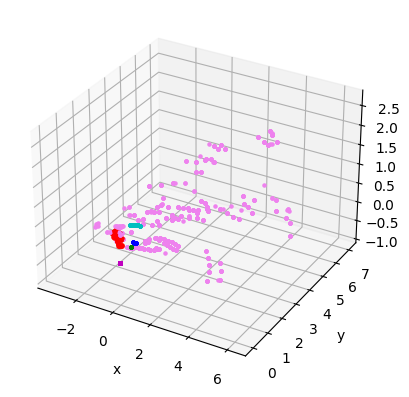

Frame : 128
==============================Print Point Clouds==============================


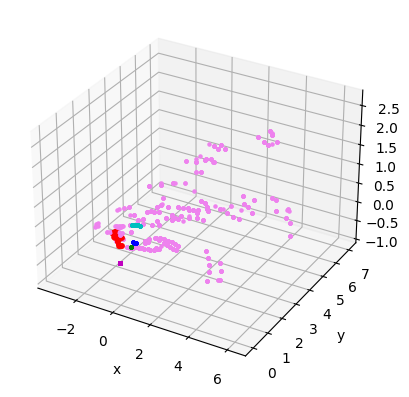

Frame : 129
==============================Print Point Clouds==============================


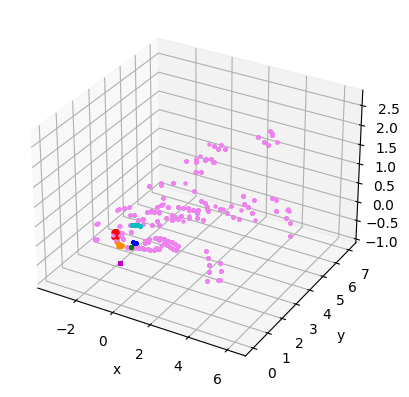

Frame : 130
==============================Print Point Clouds==============================


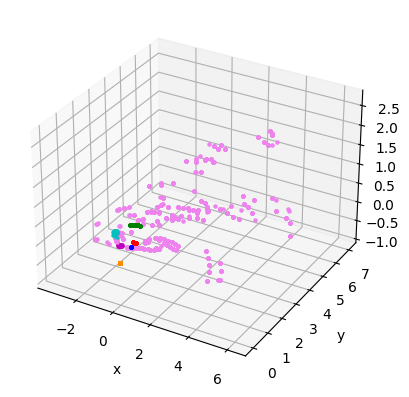

In [18]:
# Clustering frame_num = 126 ,EPS=0.1,sample = 10

for i in range(126,131):
    startFrame = i
    print("Frame : %d" % i)
    dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_SAMPLES)
    datalist = data[(data.Frame>=startFrame)&(data.Frame<startFrame+WINDOW)]

    ModelCluster(datalist, dbscan, sample_weight=False) # sample_weight = True or False

==============================Print Point Clouds==============================


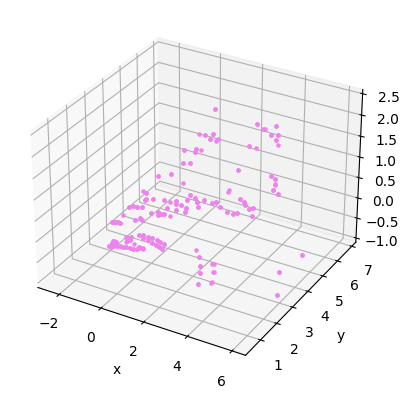

In [46]:
# Clustering frame_num = 126 ,EPS=0.1,sample = 10
WINDOW = 5

startFrame = 60
dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_SAMPLES)
datalist = data[(data.Frame>=startFrame)&(data.Frame<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False) # sample_weight = True or False

==============================Print Point Clouds==============================


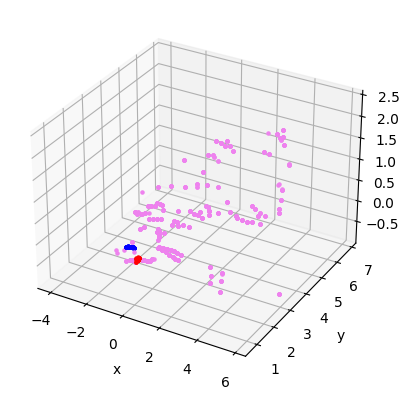

In [74]:
# Clustering frame_num = 126 ,EPS=0.1,sample = 10

WINDOW = 5

# Define global variables (dbscan)
DBSCAN_EPS = 0.1
DBSCAN_SAMPLES = 10

startFrame = 826
dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_SAMPLES)
datalist = data[(data.Frame>=startFrame)&(data.Frame<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False) # sample_weight = True or False

# ========================================

==============================Print Point Clouds==============================


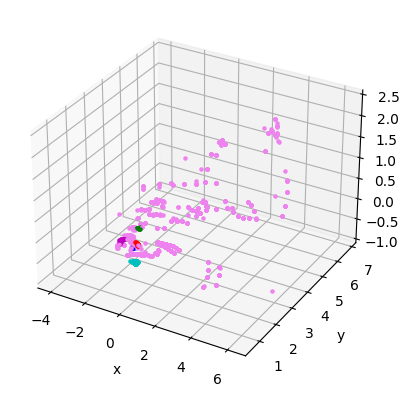

In [75]:
# Clustering frame_num = 126 ,EPS=0.1,sample = 10

WINDOW = 5

# Define global variables (dbscan)
DBSCAN_EPS = 0.1
DBSCAN_SAMPLES = 10

startFrame = 900
dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_SAMPLES)
datalist = data[(data.Frame>=startFrame)&(data.Frame<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False) # sample_weight = True or False

# Estimate boundary for each cluster (extension, orientation)
計算每個集群的邊界（擴展、方向）

In [20]:
WINDOW = 1

# Define global variables (dbscan)
DBSCAN_EPS = 0.1
DBSCAN_SAMPLES = 10

In [77]:
# Number of points in each cluster

def ClusterAnalysis(labels):
    print('Total:', len(labels), 'points,', len(np.unique(labels))-1, 'clusters')
    print(np.max(np.unique(labels))) # how many labels
    2222222
    for i in range(np.max(np.unique(labels))+1):
        print('Cluster', i, ':', np.sum(labels==i), 'points')
    print('Noise:', np.sum(labels==-1), 'points')

In [24]:
# Weighted centroid position of current cluster (該群的加權質心位置)

def ClusterCenter(clusterlist):
    # return np.average(clusterlist[['x','y','z']], axis=0, weights=Weight(clusterlist))
    return np.average(clusterlist[['X','Y','Z']], axis=0,weights=None)

In [42]:
# Clustering frame_num = 153~157

startFrame = 60
dbscan = DBSCAN(eps=0.1, min_samples=10)
datalist = data[(data.Frame>=startFrame)&(data.Frame<startFrame + WINDOW)]

clustering = ModelCluster(datalist, dbscan, sample_weight=False, show_plot=False, return_cluster=True)
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [78]:
#EPS = 0.1,sample = 10,Frame=153

ClusterAnalysis(clustering.labels_)

Total: 639 points, 3 clusters
2
Cluster 0 : 40 points
Cluster 1 : 32 points
Cluster 2 : 19 points
Noise: 548 points


In [27]:
# Weighted centroid position of 0-th cluster at 0-th timeStep(第 0 群在第 153 貞的加權質心位置)

clusterlist = datalist[clustering.labels_==0]  # cluster 0 center
cluster_center = ClusterCenter(clusterlist)
print(cluster_center)

[-0.79024553  1.04096488  0.08895334]


In [21]:
data = pd.read_csv('./File/PointCloud_2023_02_21_14_59.csv')

In [ ]:
# 1579 ~ 1645
# 769 ~ 1024 (影片上的幀數)
# 395 ~ 650
# 1200 ~ 1350 (影片上的幀數)
# 826 ~ 976 (影片上的幀數)

In [72]:
WINDOW = 5
A = []
# Define global variables (dbscan)
DBSCAN_EPS = 0.1
DBSCAN_SAMPLES = 10

for i in range(60,976,WINDOW):
    startFrame = i
    dbscan = DBSCAN(eps=0.1, min_samples=10)
    datalist = data[(data.Frame >= startFrame)&(data.Frame < startFrame + WINDOW)]

    clustering = ModelCluster(datalist, dbscan, sample_weight=False, show_plot=False, return_cluster=True)
    clusterlist = datalist[clustering.labels_==0]  # cluster 0 center
    cluster_center = ClusterCenter(clusterlist)
    # if cluster_center == 'nan':
    #     cluster_center = [0,0,0]
    # print(cluster_center)
    A.append(cluster_center)
    # print(len(A))
    # print(A) 

c:\Users\user\anaconda3\envs\yolov5_python3.9\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\anaconda3\envs\yolov5_python3.9\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\user\anaconda3\envs\yolov5_python3.9\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\user\anaconda3\envs\yolov5_python3.9\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


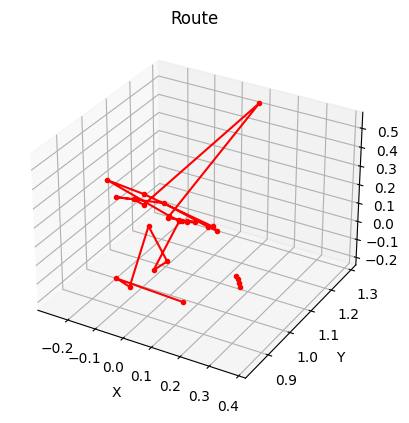

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 處理資料，將每個時刻的x、y和z座標存儲在二維陣列中，例如:
# data = [[-2.658551, 2.741712, 0.538183], [-2.663078, 2.746380, 0.855460	], [5.692171, 2.897134, 1.563014]]

# 將x、y和z座標分別存儲在不同的陣列中
x = [d[0] for d in A]
y = [d[1] for d in A]
z = [d[2] for d in A]

# 繪製三維移動路徑
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'r.-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Route')
plt.show()

# ==============================================

In [ ]:
# Calculate covariance of centroid function of current cluster (clusterlist: list of points), with two methods 

# Method 1 (orientation=True): Estimating arbitrary orientation           (估計任意方向)
# Method 2 (orientation=False): Set orientation to defuault axes-oriented (將方向設置為默認軸方向)

def CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=True):
    if orientation:
        cluster_cov = np.zeros((3,3))
        for i in range(len(clusterlist.index)):
            cluster_cov += cluster_pt_weight[i]*np.dot(HorToVer(np.array(clusterlist[['X','Y','Z']])[i]-cluster_center), VerToHor(np.array(clusterlist[['X','Y','Z']])[i]-cluster_center))
    else:
        cluster_cov = np.zeros(3)
        for i in range(len(clusterlist.index)):
            cluster_cov[0] += cluster_pt_weight[i]*np.dot(np.array(clusterlist.X)[i]-cluster_center[0], np.array(clusterlist.X)[i]-cluster_center[0])
            cluster_cov[1] += cluster_pt_weight[i]*np.dot(np.array(clusterlist.Y)[i]-cluster_center[1], np.array(clusterlist.Y)[i]-cluster_center[1])
            cluster_cov[2] += cluster_pt_weight[i]*np.dot(np.array(clusterlist.Z)[i]-cluster_center[2], np.array(clusterlist.Z)[i]-cluster_center[2])

    cluster_cov = cluster_cov/np.sum(cluster_pt_weight)
    return cluster_cov     

In [ ]:
# Shift (l,w,h) order in arbitrary orientations so they align (as close as possible) with 3 axes

def ShiftAxis(cluster_extension, cluster_orientation):
    shift_index = np.zeros((3,3))
    for axis in range(3):
        for idx in range(3):
            shift_index[axis, idx] = VectorAngle(cluster_orientation[idx], np.identity(3)[axis])
    shift_index = linear_sum_assignment(shift_index, maximize=True)[1] # Hungarian Algorithm, column index
    
    cluster_orientation = cluster_orientation[shift_index]
    cluster_extension = cluster_extension[shift_index]
    
    for idx in range(3):
        if np.dot(cluster_orientation[idx], np.identity(3)[idx])<0:
            cluster_orientation[idx] = -cluster_orientation[idx]
    
    return cluster_extension, cluster_orientation

In [ ]:
# Estimate extension of the cluster (預測集群的擴展)

def ClusterExtension(clusterlist, orientation = True):
    cluster_pt_weight = Weight(clusterlist)
    cluster_center = ClusterCenter(clusterlist)

    if orientation:
        cluster_cov = CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=orientation)
        # cluster_npcov = np.cov(np.array(clusterlist[['x','y','z']]), rowvar=False, aweights=cluster_pt_weight) # Or use default weighted cov function from numpy (slightly difference in extension, same in orientation)

        cluster_extension, cluster_orientation = np.linalg.eig(cluster_cov) # Use eigenvalue, eigenvector for estimating extension, orientation
        cluster_extension = np.sqrt(cluster_extension)*6 # Gaussian 3-sigma rule
        cluster_orientation = cluster_orientation.T
        
        cluster_extension, cluster_orientation = ShiftAxis(cluster_extension, cluster_orientation)

    else:
        # Orientation set default to along axes
        ## Method 1: box constraint
        # cluster_extension = np.array([np.max(clusterlist.x) - np.min(clusterlist.x), np.max(clusterlist.y) - np.min(clusterlist.y), np.max(clusterlist.z) - np.min(clusterlist.z)])
        
        ## Method 2: assume points in each axis is normal distribution
        cluster_cov = CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=orientation)
        cluster_extension = np.sqrt(cluster_cov)*6 # Gaussian 3-sigma rule
        cluster_orientation = np.identity(3)

    return cluster_extension, cluster_orientation

In [ ]:
# Esimate extension of 0-th cluster at 0-th timeStep

# With orientation
cluster_extension, cluster_orientation = ClusterExtension(clusterlist)
print('With orientation estimation:')
print('length:', cluster_extension[0])
print('width:', cluster_extension[1])
print('height:', cluster_extension[2])
print('orientation:', cluster_orientation[np.argmax(cluster_extension)])

# Without orientation
cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=False)
print('\nWithout orientation estimation:')
print('length:', cluster_extension[0])
print('width:', cluster_extension[1])
print('height:', cluster_extension[2])
print('orientation:', cluster_orientation[np.argmax(cluster_extension)])

In [ ]:
# Plot the 3-d Ellipsoid on the Axes3D ax.

def PlotEllipsoid(ax, center, orientation, color='dodgerblue', npoints=100):
    # Set points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, npoints)
    v = np.linspace(0.0, np.pi, npoints)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j], y[i,j], z[i,j] = center + np.dot(orientation, [x[i,j], y[i,j], z[i,j]])

    ax.plot_wireframe(x, y, z,  rstride=10, cstride=10, color=color, alpha=0.2, linewidth=1)

In [ ]:
def PlotArrow(ax, center, orientation, extension=np.ones(3)/2):
    # center: array 1x3
    # orientation: matrix 3x3
    # extension: array 1x3
    ax.quiver(center[0], center[1], center[2], orientation[0][0], orientation[0][1], orientation[0][2], length=extension[0], color='tab:blue', normalize=True)
    ax.quiver(center[0], center[1], center[2], orientation[1][0], orientation[1][1], orientation[1][2], length=extension[1], color='tab:orange', normalize=True)
    ax.quiver(center[0], center[1], center[2], orientation[2][0], orientation[2][1], orientation[2][2], length=extension[2], color='tab:green', normalize=True)

In [ ]:
def PlotClusterEllipsoid(ax, clusterlist, orientation=True,  plot_arrow=True, color='dodgerblue'):
    cluster_center = ClusterCenter(clusterlist)
    cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=orientation)
    print('Center=', cluster_center, '\tL=', cluster_extension[0], '\tW=', cluster_extension[1], '\tH=', cluster_extension[2], '\tDirection=', cluster_orientation[np.argmax(cluster_extension)])

    # Plot center
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], color='r', marker='.')

    # Plot ellipsoid
    PlotEllipsoid(ax, cluster_center, (cluster_orientation * HorToVer(cluster_extension)/2).T, color=color)
    
    # Plot orientation arrow
    if plot_arrow:
        PlotArrow(ax, cluster_center, cluster_orientation, cluster_extension/2)

In [ ]:
# Estimate extension of all clusters at 0-th timeStep (default orientation on axes)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
PlotSetting(ax)

PlotData(ax, datalist, color=GetColors(clustering.labels_))

for i in range(np.max(np.unique(clustering.labels_))+1):
    PlotClusterEllipsoid(ax, datalist[clustering.labels_==i], orientation=False, plot_arrow=True, color=GetColors([i]))
PlotData(ax, datalist[clustering.labels_==-1], color='k')

plt.show()

# Cluster-based Observation state
集群的觀察狀態

In [ ]:
def InitObservationDataFrame():
    return pd.DataFrame(columns=['Frame','cluster_num','track_num','x','y','z','l','w','h','ori_x','ori_y','ori_z','cov','pts'])

In [ ]:
# Output combined observation estimations to Z(k,n)  將組合觀測估計輸出到 Z(k,n)

def GenerateObservationStates(data, startFrame, endFrame, orientation=True):
    observation_states = InitObservationDataFrame()

    for frame_num in range(startFrame, endFrame+1):
        dbscan = DBSCAN(eps=0.1, min_samples=10)
        datalist = data[(data.Frame>=frame_num)&(data.Frame<frame_num + WINDOW)]

        clustering = ModelCluster(datalist, dbscan, sample_weight=False, show_plot=False, return_cluster=True)

        for cluster_num in range(-1, np.max(np.unique(clustering.labels_))+1):
            clusterlist = datalist[clustering.labels_==cluster_num]
            
            observation_state = InitObservationDataFrame()
            # print(type(frame_num))
            observation_state.at[0,'Frame'] = frame_num
            observation_state.at[0,'cluster_num'] = cluster_num
            observation_state.at[0,'track_num'] = cluster_num # Initial track_num, before mapping to tracks
            observation_state.at[0,'pts'] = list(clusterlist.index)
            
            if cluster_num != -1:
                cluster_center = ClusterCenter(clusterlist)
                cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=orientation)
                cluster_pt_weight = Weight(clusterlist)
                cluster_cov = CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=orientation)

                observation_state.at[0,'x'] = cluster_center[0]
                observation_state.at[0,'y'] = cluster_center[1]
                observation_state.at[0,'z'] = cluster_center[2]

                observation_state.at[0,'l'] = cluster_extension[0]
                observation_state.at[0,'w'] = cluster_extension[1]
                observation_state.at[0,'h'] = cluster_extension[2]

                observation_state.at[0,'ori_x'] = cluster_orientation[0]
                observation_state.at[0,'ori_y'] = cluster_orientation[1]
                observation_state.at[0,'ori_z'] = cluster_orientation[2]
                observation_state.at[0,'cov'] = cluster_cov

            observation_states = observation_states.append(observation_state, ignore_index=True)
        
        print('Frame ', frame_num, 'is done.')

    return observation_states

In [ ]:
observation_states = GenerateObservationStates(data, 153, 157, orientation=True)
observation_states

# Track-based estimated state
基於軌道估計狀態

In [ ]:
def InitEstimateDataFrame():
    return pd.DataFrame(columns=['Frame','track_num','X','Y','Z','vx','vy','vz','l','w','h','ori_x','ori_y','ori_z','cov','pts'])

In [ ]:
# frame = k, track_num(群) = t =>s(k,t) = [position,velocity,extension,orientation]
# Initialize S(0,t) from Z(0,n)
# Initial data association between n and t: n=t

def InitEstimateState(observation_states, startFrame):
    estimate_states = InitEstimateDataFrame()
    
    init_observation_states = observation_states[(observation_states.Frame==startFrame)&(observation_states.cluster_num!=-1)]
    for i in list(init_observation_states.index):
        estimate_states.at[i,'Frame'] = init_observation_states.loc[i,'Frame']
        estimate_states.at[i,'track_num'] = init_observation_states.loc[i,'track_num']
        estimate_states.at[i,'X'] = init_observation_states.loc[i,'x']
        estimate_states.at[i,'Y'] = init_observation_states.loc[i,'y']
        estimate_states.at[i,'Z'] = init_observation_states.loc[i,'z']
        estimate_states.at[i,'vx'] = 0
        estimate_states.at[i,'vy'] = 0
        estimate_states.at[i,'vz'] = 0
        estimate_states.at[i,'l'] = init_observation_states.loc[i,'l']
        estimate_states.at[i,'w'] = init_observation_states.loc[i,'w']
        estimate_states.at[i,'h'] = init_observation_states.loc[i,'h']
        estimate_states.at[i,'ori_x'] = init_observation_states.loc[i,'ori_x']
        estimate_states.at[i,'ori_y'] = init_observation_states.loc[i,'ori_y']
        estimate_states.at[i,'ori_z'] = init_observation_states.loc[i,'ori_z']
        estimate_states.at[i,'cov'] = np.zeros((9,9))
        estimate_states.at[i,'pts'] = init_observation_states.loc[i,'pts']

    return estimate_states

In [ ]:
estimate_states = InitEstimateState(observation_states, 153)
estimate_states

# Kalman Filter algorithm

In [ ]:
# Define global parameters for KF algorithm

FPS = 10
DELTA_T = WINDOW / FPS
sigma_R = 0.03
sigma_theta = np.pi/24
sigma_phi = np.pi/24
sigma_ax = 8
sigma_ay = 8
sigma_az = 0
sigma_l = 0.001
sigma_w = 0.001
sigma_h = 0.001

In [ ]:
from scipy.linalg import block_diag

KF_F = block_diag(np.kron(np.matrix([[1,DELTA_T],[0,1]]), np.identity(3)), np.identity(3))
KF_H = np.concatenate((np.concatenate((np.identity(3),np.zeros((3,6))), axis=1), np.concatenate((np.zeros((3,6)), np.identity(3)), axis=1)))
KF_g = np.array([[DELTA_T**2/2], [DELTA_T]])
KF_Q = block_diag(np.kron(KF_g*KF_g.T, np.diag([sigma_ax**2, sigma_ay**2, sigma_az**2])), np.diag([sigma_l**2, sigma_w**2, sigma_h**2]))

In [ ]:
# KF_R depending on (x,y,z)

def CalcR(x, y, z):
    R, theta, phi = CarToSph(x, y, z)
    
    # Jacobian matrix
    KF_J = np.matrix([[np.cos(theta)*np.sin(phi), -R*np.sin(theta)*np.sin(phi), R*np.cos(theta)*np.cos(phi)], 
                      [np.sin(theta)*np.sin(phi), R*np.cos(theta)*np.sin(phi), R*np.sin(theta)*np.cos(phi)], 
                      [np.cos(phi), 0, -R*np.sin(phi)]])

    KF_R_pol = np.diag([sigma_R**2, sigma_theta**2, sigma_phi**2])
    return KF_J.dot(KF_R_pol).dot(KF_J.T)

In [ ]:
# KF_R = block_diag(CalcR(x, y, z), observation_state_cov)

def KF_R(position, observation_cov):
    return block_diag(CalcR(position[0], position[1], position[2]), observation_cov)

In [ ]:
# Kalman filter updating
def KF_Update(frame_num, observation_states, estimate_states, track_states):
    print(track_states)
    if frame_num == 0:
        estimate_states = InitEstimateState(observation_states, frame_num)
    else:
        for track_num in track_states[track_states.Frame==frame_num].track_num:
            # s_k (of track_num) not exist: initialize new track
            if track_num not in list(np.unique(estimate_states.track_num)):
                estimate_states = estimate_states.append(InitEstimateState(observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)], frame_num), ignore_index=True)
            # s_k (of track_num) exist
            else:
                z_state = np.array(observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)].iloc[0][['x','y','z','l','w','h']])
                z_cov = observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)]['cov'].to_numpy()[0]

                estimate_track_idx = np.max(estimate_states.index[(estimate_states.Frame<frame_num)&(estimate_states.track_num==track_num)])
                s_state = np.array(estimate_states.loc[estimate_track_idx][['x','y','z','vx','vy','vz','l','w','h']])
                s_cov = estimate_states.loc[estimate_track_idx]['cov']

                # Time update (predict)
                s_state = KF_F.dot(s_state)
                s_cov = KF_F.dot(s_cov).dot(KF_F.T) + KF_Q

                # Measurement update (correct)
                KF_K = KF_H.dot(s_cov).dot(KF_H.T) + KF_R(z_state[:3], z_cov)
                DA_confidence = list(track_states.quality[track_states.track_num==track_num])[0]  # Include DA confidence (new!)
                s_state = s_state + s_cov.dot(KF_H.T).dot(np.linalg.inv(KF_K)).dot(z_state-KF_H.dot(s_state)) * DA_confidence
                s_cov = s_cov - s_cov.dot(KF_H.T).dot(np.linalg.inv(KF_K)).dot(KF_H).dot(s_cov) * DA_confidence

                estimate_state = InitEstimateDataFrame()
                estimate_state.at[0,'frame_num'] = frame_num
                estimate_state.at[0,'track_num'] = track_num
                estimate_state.at[0,['x','y','z']] = s_state[:3]
                estimate_state.at[0,['vx','vy','vz']] = s_state[3:6]
                estimate_state.at[0,['l','w','h']] = s_state[6:]
                estimate_state.at[0,'ori_x'] = observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)]['ori_x'].to_numpy()[0]
                estimate_state.at[0,'ori_y'] = observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)]['ori_y'].to_numpy()[0]
                estimate_state.at[0,'ori_z'] = observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)]['ori_z'].to_numpy()[0]
                estimate_state.at[0,'cov'] = s_cov
                estimate_state.at[0,'pts'] = observation_states[(observation_states.Frame==frame_num)&(observation_states.track_num==track_num)]['pts'].to_numpy()[0]

                estimate_states = estimate_states.append(estimate_state, ignore_index=True)
    return estimate_states

# Data association (n ↔ t)

In [ ]:
# Define global parameters for data association

DA_BETA = 0.01           # Bias term (beta): in score matrix equation
DA_THRESHOLD = 0.15      # low-pass filter: in score matrix, probability score<threshold is set to 0
DA_TRACK_COUNT = 30      # n (in m-n rule): for track initialization, track appear "m out of n" is intialized
DA_TRACK_APPEARANCE = 10 # m in (m-n rule): for track initialization, track appear "m out of n" is intialized

In [ ]:
# Generate (z_state, z_cov) from observation_states

def GenerateZstates(frame_num, observation_states):
    z_state = observation_states[(observation_states.Frame==frame_num)&(observation_states.cluster_num!=-1)][['cluster_num','x','y','z','l','w','h']]
    z_cov = observation_states[(observation_states.Frame==frame_num)&(observation_states.cluster_num!=-1)][['cluster_num','cov']]

    if frame_num == 0:
        for i in list(z_state.index):
            z_state.track_num[i] = z_state.cluster_num[i]

    return z_state, z_cov

# Generate (s_state, s_cov) from estimate_states

def GenerateSstates(frame_num, estimate_states, track_states):
    s_state = pd.DataFrame(columns=['track_num','x','y','z','vx','vy','vz','l','w','h'])
    s_cov = pd.DataFrame(columns=['track_num', 'cov'])
    for i in range(len(track_states)):
        s_state = s_state.append(estimate_states[(estimate_states.track_num==track_states.iloc[i].track_num)&(estimate_states.frame_num==track_states.iloc[i].frame_num)][['track_num','x','y','z','vx','vy','vz','l','w','h']])
        s_cov = s_cov.append(estimate_states[(estimate_states.track_num==track_states.iloc[i].track_num)&(estimate_states.frame_num==track_states.iloc[i].frame_num)][['track_num','cov']])

    return s_state, s_cov

In [ ]:
# Calculate G(n,t)
# z_state, z_cov: cluster-based measurement
# s_state, s_cov: track-based prediction

def CalcGLikelihood(z_state, z_cov, s_state, s_cov):
    n_count = list(np.unique(z_state.cluster_num)) # Existing cluster number at current frame_num
    t_count = list(np.unique(s_state.track_num)) # Existing track number
    G = np.zeros((len(n_count), len(t_count)))
    
    for n in range(len(n_count)):
        for t in range(len(t_count)):
            z_n = np.array(z_state[z_state.cluster_num==n_count[n]].iloc[0][['x','y','z','l','w','h']])
            s_t = np.array(s_state[s_state.track_num==t_count[t]].iloc[0][['x','y','z','vx','vy','vz','l','w','h']])
            gamma_nt = z_n - KF_H.dot(s_t)
            R_n = KF_R(z_n[:3], z_cov[z_cov.cluster_num==n_count[n]]['cov'].to_numpy()[0])
            K_nt = KF_H.dot(KF_F.dot(s_cov[s_cov.track_num==t_count[t]]['cov'].to_numpy()[0]).dot(KF_F.T)+KF_Q).dot(KF_H.T) + R_n
            G[n,t] = np.exp(-gamma_nt.T.dot(np.linalg.inv(K_nt)).dot(gamma_nt)/2)/np.sqrt(np.linalg.det(K_nt))
    return G

In [ ]:
# Calculate P(n,t)
# P(n,t) = G(n,t)/(sum(G(n,t) on n)+sum(G(n,t) on t)-G(n,t)+beta)

def CalcScoreMatrix(G):
    score_matrix = np.zeros_like(G)
    n_count, t_count = G.shape
    G_tsum = np.sum(G, axis=1)
    G_nsum = np.sum(G, axis=0)

    for n in range(n_count):
        for t in range(t_count):
            score_matrix[n,t]=G[n,t]/(G_tsum[n]+G_nsum[t]-G[n,t]+DA_BETA)
    return score_matrix

In [ ]:
# Find s(k,t) from z(k,n) and s(0:k-1,t)
def ClusterTrackMapping(frame_num, observation_states, estimate_states):
    z_state, z_cov = GenerateZstates(frame_num, observation_states)
    s_state, s_cov = GenerateSstates(frame_num, estimate_states)
    
    if frame_num != 0:
        g_matrix = CalcGLikelihood(z_state, z_cov, s_state, s_cov)
        score_matrix = CalcScoreMatrix(g_matrix)

        # Use score matrix to map n↔t
        track_max = np.max(estimate_states[estimate_states.Frame<frame_num].track_num)
        mapping_track_idx = linear_sum_assignment(score_matrix, maximize=True)[1] # Hungarian Algorithm, column index

        n_count = list(np.unique(z_state.cluster_num)) # Existing cluster number at current frame_num
        t_count = list(np.unique(s_state.track_num)) # Existing track number
        for i in range(len(n_count)):
            if score_matrix[i, mapping_track_idx[i]] >= DA_THRESHOLD: # TODO: hard threshold not good
                # i-th cluster in n_count ↔ mapping_idx[i]-th track in t_count
                z_state.at[z_state[z_state.cluster_num==n_count[i]].index[0], 'track_num'] = t_count[mapping_track_idx[i]]
            else:
                # i-th cluster in n_count ↔ new (++track_max) track
                track_max += 1
                z_state.at[z_state[z_state.cluster_num==n_count[i]].index[0], 'track_num'] = track_max

    for i in list(z_state.index):
        observation_states.track_num[i] = z_state.track_num[i]
    return observation_states # with updated track_num